# Imports

In [1]:
using CSV, DataFrames, MarketData, Statistics, Ipopt, JuMP, Plots,Dates, LinearAlgebra, GLM, MultivariateStats
using NearestNeighbors, ARCHModels, Random, Dates, FinancialToolbox
find(x)=findall(x1 -> x1,vec(x))

find (generic function with 1 method)

# Question 1

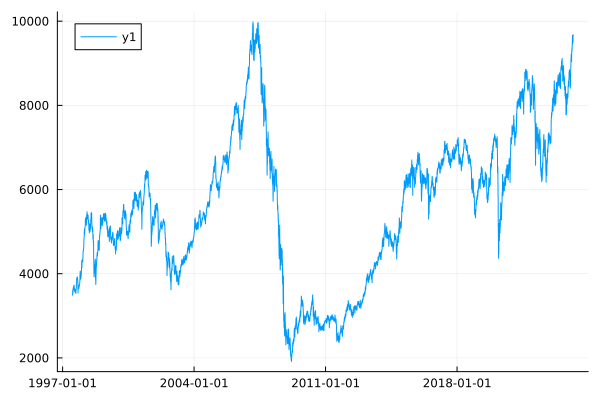

In [2]:
using Dates
df=DataFrame(yahoo("^ISEQ"))
df = dropmissing(df, :AdjClose)
iseq=df.AdjClose
cdate=df[:,1]
plot(cdate,iseq)

## Part a

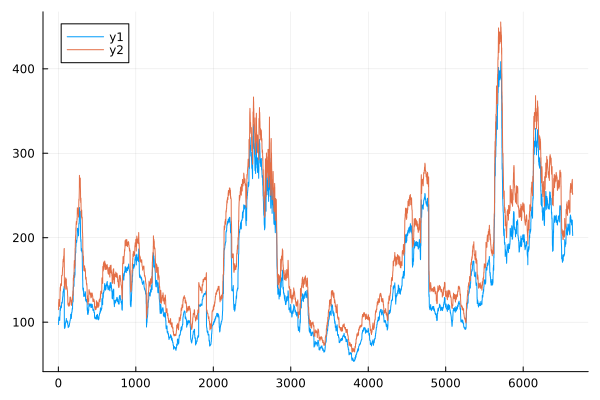

In [3]:
Rets = log.(iseq[2:end] ./ iseq[begin:end - 1]);
movingaverage(g, n) = [mean(g[i-n+1:i]) for i in n:length(g)]
movingvol(g, n) = [sqrt(mean(g[i-n+1:i].^2) - mean(g[i-n+1:i])^2) for i in n:length(g)]
RollingMeanRet = movingaverage(Rets, 100)
RollingVol = movingvol(Rets, 100);
VAR(s, mean, vol, n) = [s[i + n] * (1 - exp(-vol[i] * 2.33 + mean[i] - vol[i]^2/2)) for i in 1:length(mean) - 1]
DailyVAR = VAR(iseq, RollingMeanRet, RollingVol, 100);
cVAR = [DailyVAR[i]+(1/.01)*blsprice(iseq[i + 100],iseq[i + 100]-DailyVAR[i],0,1,RollingVol[i],0,false) for i in 1:length(DailyVAR)];
plot(DailyVAR, label = "VaR")
plot!(cVAR, label = "Expected Shortfall")

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\rowan\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\rowan\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148


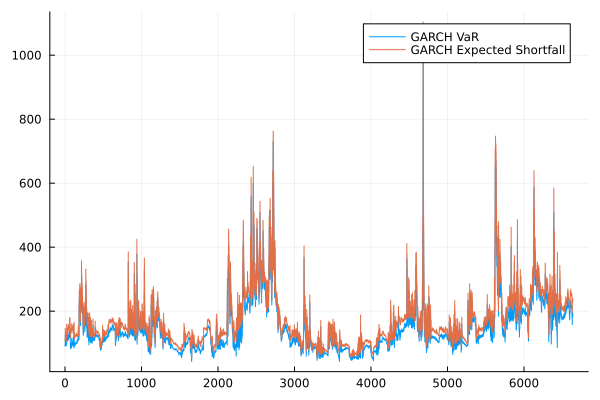

In [4]:
T = length(Rets)
WindowSize = 100
vars = similar(Rets)
cvars = similar(Rets)
for t in WindowSize:T-1
    m = fit(GARCH{1, 1}, Rets[t-(WindowSize-1):t])
    vars[t+1] = predict(m, :VaR; level = 0.01)
    vol = predict(m, :volatility; )
    cvars[t+1] = iseq[t + 2] * vars[t + 1] + 1/0.01 * blsprice(iseq[t + 2], iseq[t + 2] * (1 - vars[t + 1]), 0,1, vol,0, false)
end;
dollarVaR = vars[(WindowSize + 1):end] .* iseq[(WindowSize + 2):end]
plot(dollarVaR, label = "GARCH VaR")
plot!(cvars[(WindowSize + 1):end], label = "GARCH Expected Shortfall")

In [5]:
vars = vars[(WindowSize + 1):end];
cvarPercent = cvars[(WindowSize + 1):end] ./ iseq[(WindowSize + 2):end];

## Efficacy Test for unscaled VaR

In [6]:
dailyVaRP = DailyVAR ./ iseq[102:end]
dailycVaRP = cVAR ./ iseq[102:end];
@show [mean(dailyVaRP) mean(dailycVaRP)]
[mean(Rets[WindowSize + 1:end] .< -dailyVaRP) mean(Rets[WindowSize + 1:end] .< -dailycVaRP)]

[mean(dailyVaRP) mean(dailycVaRP)] = [0.028157670976812845 0.03247403793343243]


1×2 Matrix{Float64}:
 0.0201807  0.013253

Predicted Daily VaR found 2% while ES found 1.3% vs. 1% expected

## Efficacy Test for Scaled VaR

In [7]:
@show [mean(vars) mean(cvarPercent)]
[mean(Rets[WindowSize + 1:end] .< -vars) mean(Rets[WindowSize + 1:end] .< -cvarPercent)]

[mean(vars) mean(cvarPercent)] = [0.028004740693700986 0.03219266754321087]


1×2 Matrix{Float64}:
 0.0216867  0.013253

Predicted Daily Scaled VaR found 2.1% while Scaled ES found 1.3% vs. 1% expected

## Part b

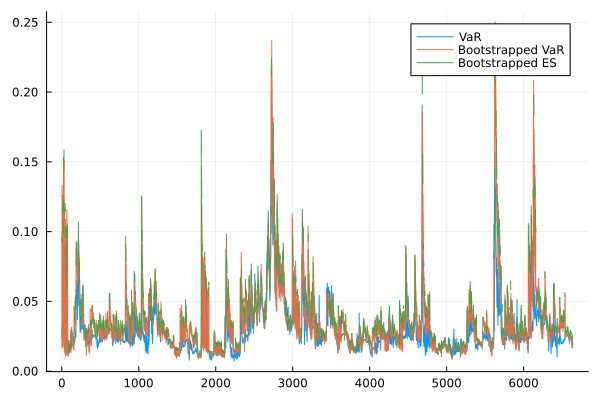

In [8]:
sd_vec=VaRs(fit(GARCH{1,1},Rets),.159);
nsim=length(Rets) - 99
evarvec=copy(vars)
eesvec=copy(cvarPercent)
i=1;
for i=101:length(evarvec)
    rtns = Rets[(i - 100):(i-1)].*sd_vec[i]./sd_vec[(i-100):(i-1)];
    bsmpl=rtns[sample(1:length(rtns),1000,replace=true)]
    evarvec[i - 100]=-quantile(bsmpl,.01)
    eesvec[i - 100]=-mean(bsmpl[bsmpl.<-evarvec[i - 100]])
end
plot(vars, label = "VaR")
plot!(evarvec, label = "Bootstrapped VaR")
plot!(eesvec, label = "Bootstrapped ES")

In [9]:
[mean(Rets[101:end] .< -evarvec) mean(Rets[101:end] .< -eesvec)]

1×2 Matrix{Float64}:
 0.0158133  0.0063253

Bootstrapped VaR found 1.58% and Bootstrapped ES found 0.63% vs 1% expected

# Question 2

## Part a

### European Put Option Price

In [10]:
blsprice(10,10.5,.04,.25,.2,0,false)

0.6346109503233762

We use a 5x5 matrix here to find the option rather than the proposed $\frac{n(n + 1)}{2}$ length array. This allows us to efficiently loop to create prices, IVs and constraints for each model. Additionally, it's easier for me to interpret, as each column corresponds to a new time step

### American Binomial and Hybrid Model

In [11]:
S = 10
K = 10.5
r = 0.01/4

u=1+0.1/sqrt(4);
d=1-0.1/sqrt(4);

s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
iv = zeros(5,5)
for j in 1:5
    for i in 1:5
        s[i,j] = S * u^(j - i) * d^(i - 1)
        iv[i,j] = max(K - s[i,j], 0)
        if i == j
            break
        end
    end
end

model1=Model(Ipopt.Optimizer)
@variable(model1,0<=p<=1)
set_silent(model1)
@constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
optimize!(model1)
p=value(p)

model2=Model(Ipopt.Optimizer)
@variable(model2,0<=w[1:4, 1:4]<=1)
@variable(model2,val[1:5, 1:5]>=0)
set_silent(model2)
for i in 1:5
    @constraint(model2, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        @constraint(model2,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
    end
end
@objective(model2,Max,val[1,1])
optimize!(model2)
println([value(val[1,1]) find(value.(w).<.001)'])

model3=Model(Ipopt.Optimizer)
@variable(model3,0<=w[1:4, 1:4]<=1)
@variable(model3,val[1:5, 1:5]>=0)
set_silent(model3)
for i in 1:5
    @constraint(model3, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        if j == 4
            @constraint(model3,val[i,j]==w[i, j]*blsprice(s[i,j],K,.04,1/16,.2,0,false)+(1-w[i,j])*iv[i,j])
        else
            @constraint(model3,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
        end
    end
end
@objective(model3,Max,val[1,1]+.01*sum((w[i,j]-.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
optimize!(model3)
println([value(val[1,1]) find(value.(w).<.001)'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[0.6734406864246626 11.0 15.0]
[0.6474261811725217 13.0 15.0 16.0]


Binomial: 0.6734 \
Hybrid: 0.6474

### European Binomial and Hybrid Model

In [12]:
S = 10
K = 10.5
r = 0.01/4

u=1+0.1/sqrt(4);
d=1-0.1/sqrt(4);

s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
iv = zeros(5,5)
for j in 1:5
    for i in 1:5
        s[i,j] = S * u^(j - i) * d^(i - 1)
        iv[i,j] = max(K - s[i,j], 0)
        if i == j
            break
        end
    end
end

model1=Model(Ipopt.Optimizer)
@variable(model1,0<=p<=1)
set_silent(model1)
@constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
optimize!(model1)
p=value(p)

model2=Model(Ipopt.Optimizer)
@variable(model2)
@variable(model2,val[1:5, 1:5]>=0)
set_silent(model2)
for i in 1:5
    @constraint(model2, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        @constraint(model2,val[i,j]==((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r))
    end
end
@objective(model2,Max,val[1,1])
optimize!(model2)
println(value(val[1,1]))
# show(stdout, "text/plain", reshape(value.(val), (5, 5)))

model3=Model(Ipopt.Optimizer)
@variable(model3,val[1:5, 1:5]>=0)
set_silent(model3)
for i in 1:5
    @constraint(model3, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        if j == 4
            @constraint(model3,val[i,j]==blsprice(s[i,j],K,.04,1/16,.2,0,false))
        else
            @constraint(model3,val[i,j]==((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r))
        end
    end
end
@objective(model3,Max,val[1,1]+.01*sum((.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
optimize!(model3)
println(value(val[1,1]))

0.655541457449106
0.6375435724331996


Binomial: 0.6555 \
Hybrid: 0.6375

## Part b

In [13]:
function Binomial4Step(S, K)
    r = 0.01/4

    u=1+0.1/sqrt(4);
    d=1-0.1/sqrt(4);

    s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
    iv = zeros(5,5)
    for j in 1:5
        for i in 1:5
            s[i,j] = S * u^(j - i) * d^(i - 1)
            iv[i,j] = max(K - s[i,j], 0)
            if i == j
                break
            end
        end
    end

    model1=Model(Ipopt.Optimizer)
    @variable(model1,0<=p<=1)
    set_silent(model1)
    @constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
    optimize!(model1)
    p=value(p)

    model2=Model(Ipopt.Optimizer)
    @variable(model2,0<=w[1:4, 1:4]<=1)
    @variable(model2,val[1:5, 1:5]>=0)
    set_silent(model2)
    for i in 1:5
        @constraint(model2, val[i, 5] == iv[i, 5])
    end

    for i in 1:4
        for j in 1:4
            @constraint(model2,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
        end
    end
    @objective(model2,Max,val[1,1])
    optimize!(model2)
    return value(val[1,1])
end
function Hybrid4Step(S, K)
    r = 0.01/4

    u=1+0.1/sqrt(4);
    d=1-0.1/sqrt(4);

    s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
    iv = zeros(5,5)
    for j in 1:5
        for i in 1:5
            s[i,j] = S * u^(j - i) * d^(i - 1)
            iv[i,j] = max(K - s[i,j], 0)
            if i == j
                break
            end
        end
    end

    model1=Model(Ipopt.Optimizer)
    @variable(model1,0<=p<=1)
    set_silent(model1)
    @constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
    optimize!(model1)
    p=value(p)

    model3=Model(Ipopt.Optimizer)
    @variable(model3,0<=w[1:4, 1:4]<=1)
    @variable(model3,val[1:5, 1:5]>=0)
    set_silent(model3)
    for i in 1:5
        @constraint(model3, val[i, 5] == iv[i, 5])
    end

    for i in 1:4
        for j in 1:4
            if j == 4
                @constraint(model3,val[i,j]==w[i, j]*blsprice(s[i,j],K,.04,1/16,.2,0,false)+(1-w[i,j])*iv[i,j])
            else
                @constraint(model3,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
            end
        end
    end
    @objective(model3,Max,val[1,1]+.01*sum((w[i,j]-.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
    optimize!(model3)
    return value(val[1,1])


end;

In [14]:
BinPrices = zeros(5)
HybridPrices = zeros(5)
EuPrices = zeros(5)
i = 1
for price in range(9, stop = 11, step = 0.5)
    BinPrices[i] = Binomial4Step(10, price)
    HybridPrices[i] = Hybrid4Step(10, price)
    EuPrices[i] = blsprice(10,price,.04,.25,.2,0,false)
    i += 1
end
TheoreticalPrices = [0.06, 0.16, 0.36, 0.65, 1.04]; # From Wolfram Alpha

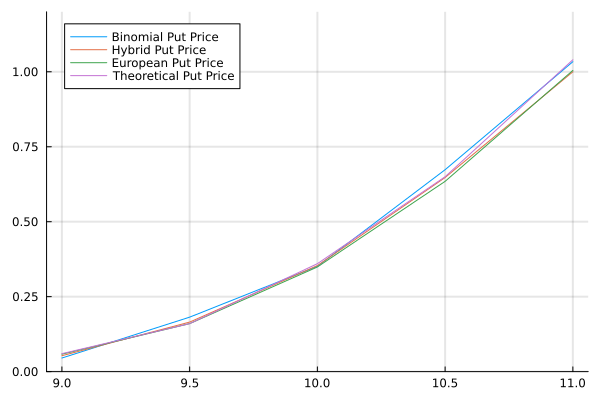

In [15]:
x = range(9, stop = 11, step = 0.5)
plot(x, BinPrices, label = "Binomial Put Price", grid=true,gridlinewidth = 2, ylim = (0,1.2))
plot!(x, HybridPrices, label = "Hybrid Put Price", grid=true)
plot!(x, EuPrices, label = "European Put Price", grid=true)
plot!(x, TheoreticalPrices, label = "Theoretical Put Price", grid=true)